# Hyperparameter Optimization for EfficientNetB0 pre-trained model

## Imports and common parameters

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
import tensorflow as tf
import platform
from tensorflow.python.client import device_lib
import tensorflow.keras
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
from visuals import *
from data.data import *
from collections import Counter

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_folder = '../data/isic2019/sampled_full'

model_folder = 'models'
history_folder = 'history'

workers = os.cpu_count()

# How to handle SVG fonts
plt.rcParams['svg.fonttype'] = 'none'

## Import Training Data

Number of known categories: 8
['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'] 

Number of unknown categories: 1
UNK 

Category to Index:
{'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'VASC': 6, 'SCC': 7, 'UNK': 8} 

Training data has 20264 samples.
'MEL':	3618	(17.85%)
'NV':	10300	(50.83%)
'BCC':	2658	(13.12%)
'AK':	694	(3.42%)
'BKL':	2099	(10.36%)
'DF':	191	(0.94%)
'VASC':	202	(1.00%)
'SCC':	502	(2.48%)
'UNK':	0	(0.00%)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,path,category
0,ISIC_0000259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/sampled_full/ISIC_2019_Traini...,1
1,ISIC_0054840,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,../data/isic2019/sampled_full/ISIC_2019_Traini...,4
2,ISIC_0057562,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/sampled_full/ISIC_2019_Traini...,1
3,ISIC_0069652,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/sampled_full/ISIC_2019_Traini...,2
4,ISIC_0061761,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/isic2019/sampled_full/ISIC_2019_Traini...,0


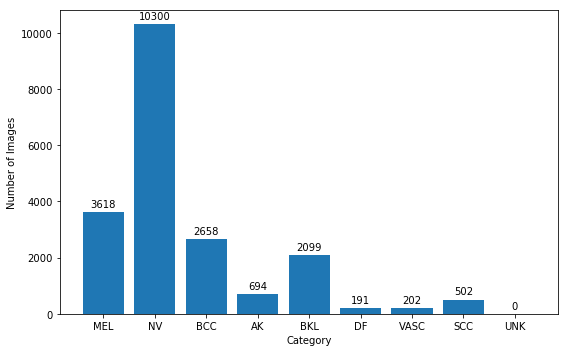

In [5]:
training_image_folder = os.path.join(data_folder, 'ISIC_2019_Training_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Training_GroundTruth.csv')

df_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(training_image_folder, ground_truth_file)
known_category_num = len(known_category_names)
print("Number of known categories: {}".format(known_category_num))
print(known_category_names, '\n')
unknown_category_num = 1
print("Number of unknown categories: {}".format(unknown_category_num))
print(unknown_category_name, '\n')
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

# mapping from category to index
print('Category to Index:')
category_to_index = dict((c, i) for i, c in enumerate(all_category_names))
print(category_to_index, '\n')

count_per_category = Counter(df_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Training data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
# plt.bar(count_per_category.keys(), count_per_category.values())
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()

df_ground_truth.head()

### Shuffle and Split Training Data into Training  and Validation Sets

In [105]:
df_train, df_val = train_validation_split(df_ground_truth)

# Training Set
sample_count_train = df_train.shape[0]
print("Training set has {} samples.".format(sample_count_train))
count_per_category_train = Counter(df_train['category'])
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category_train[i], count_per_category_train[i]*100/sample_count_train))

# Validation Set
sample_count_val = df_val.shape[0]
print("\nValidation set has {} samples.".format(sample_count_val))

Training set has 4796 samples.
'MEL':	856	(17.85%)
'NV':	2440	(50.88%)
'BCC':	629	(13.12%)
'AK':	164	(3.42%)
'BKL':	497	(10.36%)
'DF':	45	(0.94%)
'VASC':	118	(2.46%)
'SCC':	47	(0.98%)
'UNK':	0	(0.00%)

Validation set has 1199 samples.


### Class Weights based on the Traning Set

Class Weights (without UNK):
'MEL':	0.700350
'NV':	0.245697
'BCC':	0.953100
'AK':	3.655488
'BKL':	1.206237
'DF':	13.322222
'VASC':	5.080508
'SCC':	12.755319


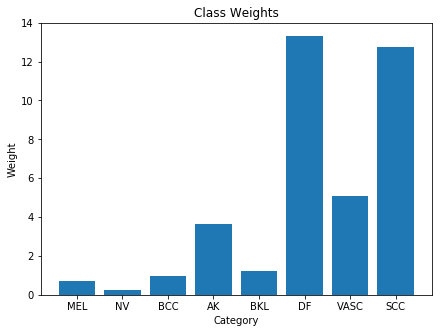

In [106]:
class_weight_dict, class_weights = compute_class_weight_dict(df_train)
print('Class Weights (without UNK):')
for i, c in enumerate(known_category_names):
    print("'%s':\t%f" % (c, class_weight_dict[i]))

# Create a bar chart
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
ax.set_title('Class Weights')
ax.set(xlabel='Category', ylabel='Weight')
plt.bar(known_category_names, [class_weight_dict[i] for i in range(known_category_num)]);

## EfficientNetB0 analysis

### Hyperparameter combinations (learning rate, dropout and batch size)

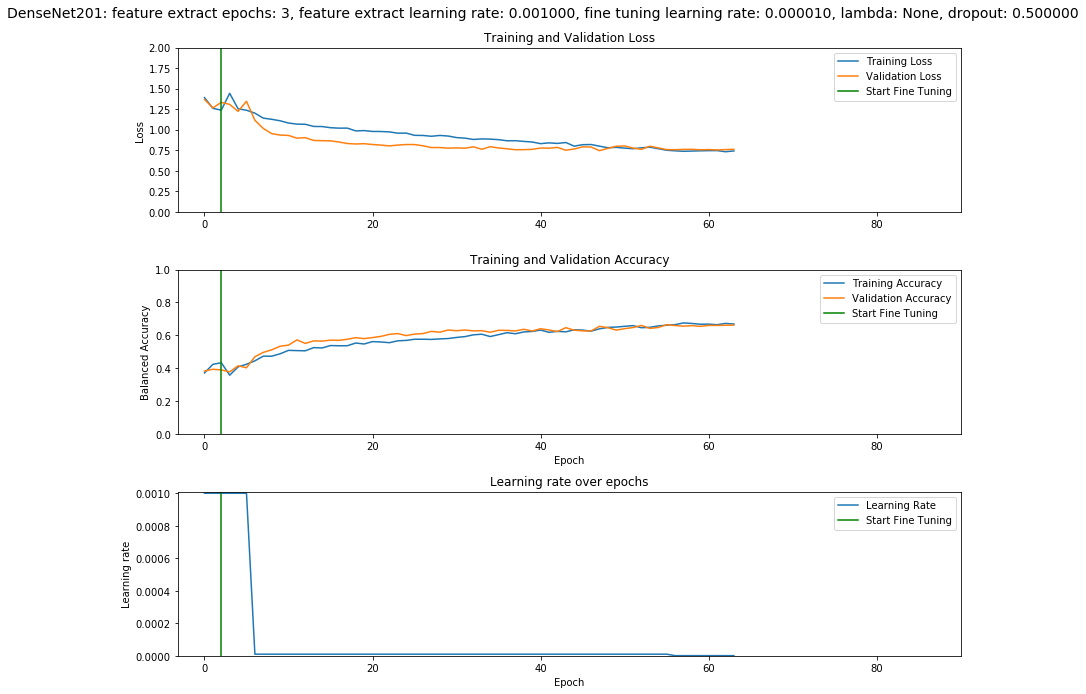

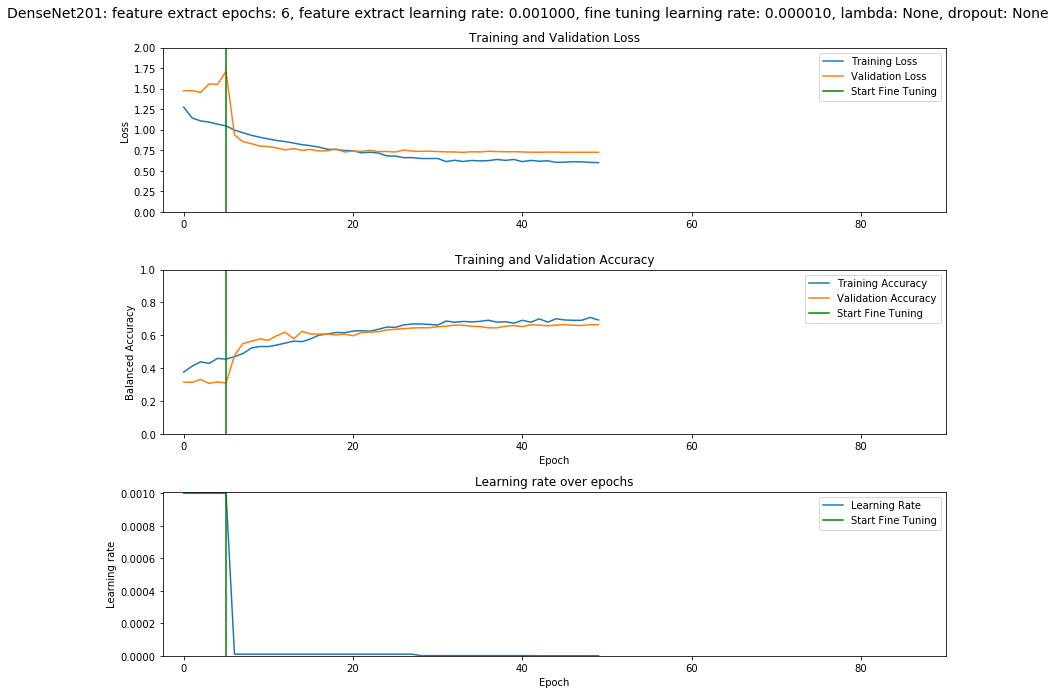

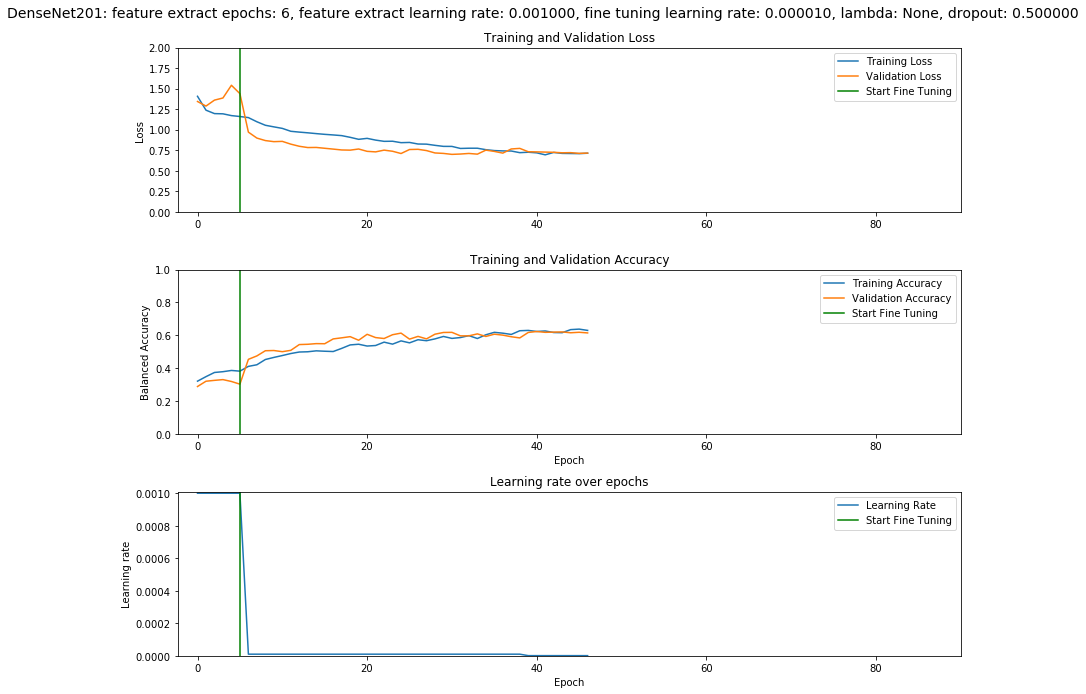

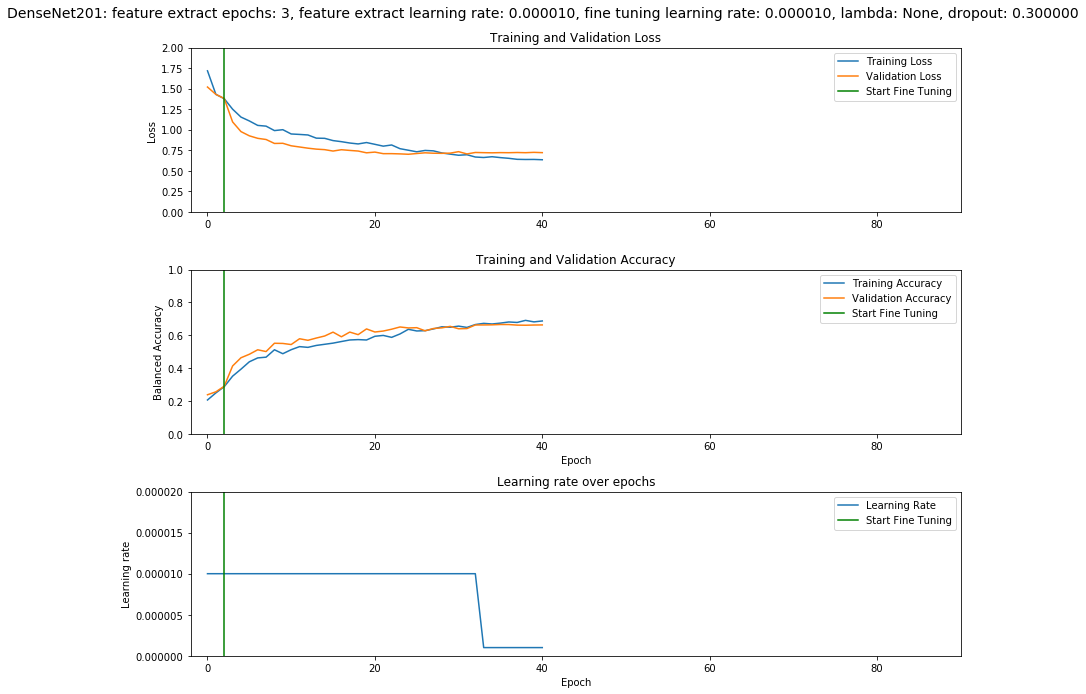

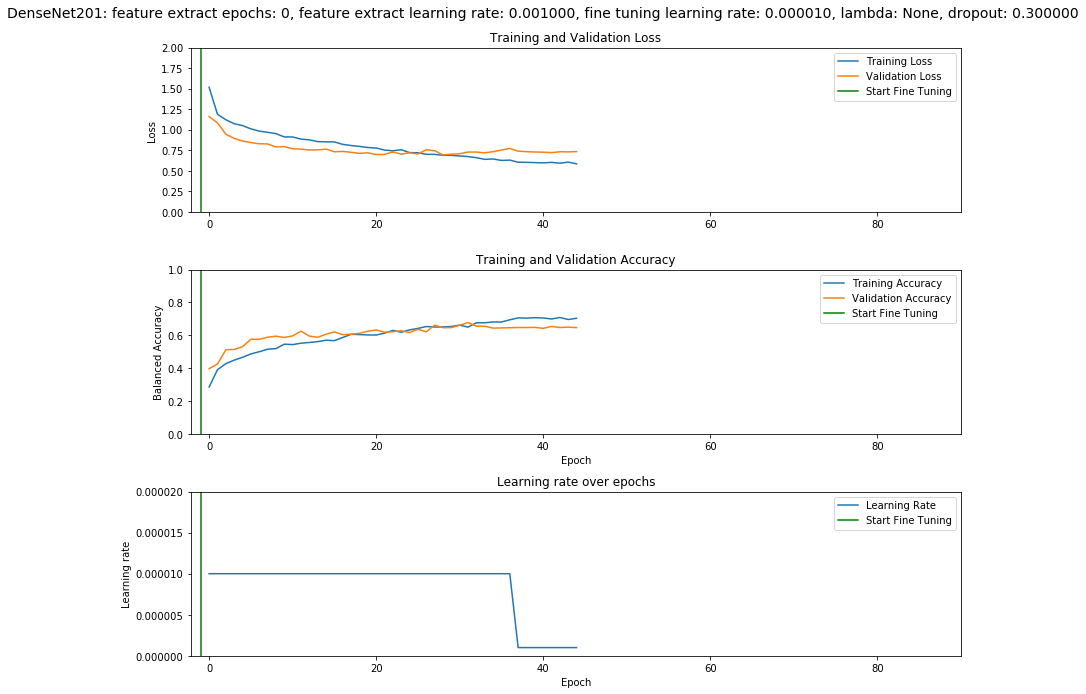

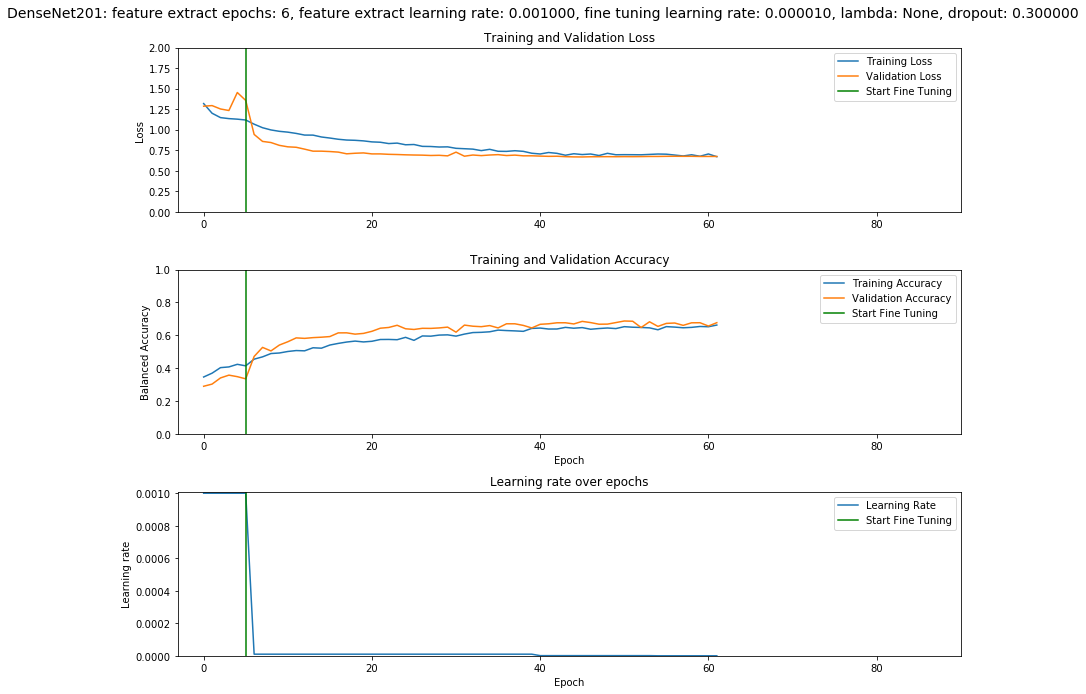

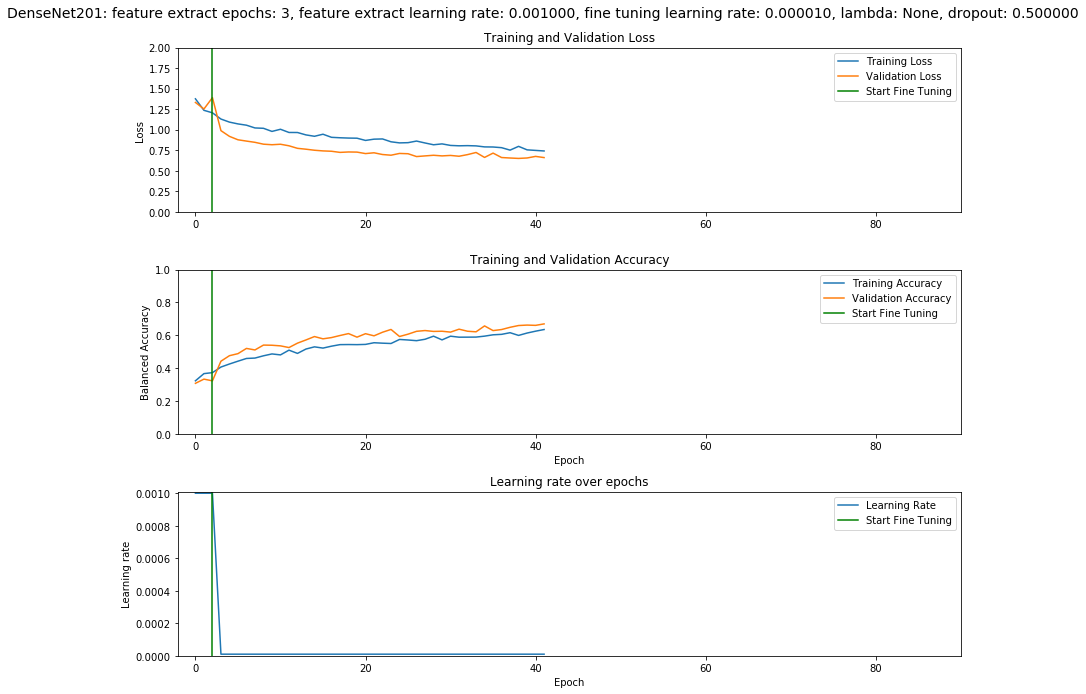

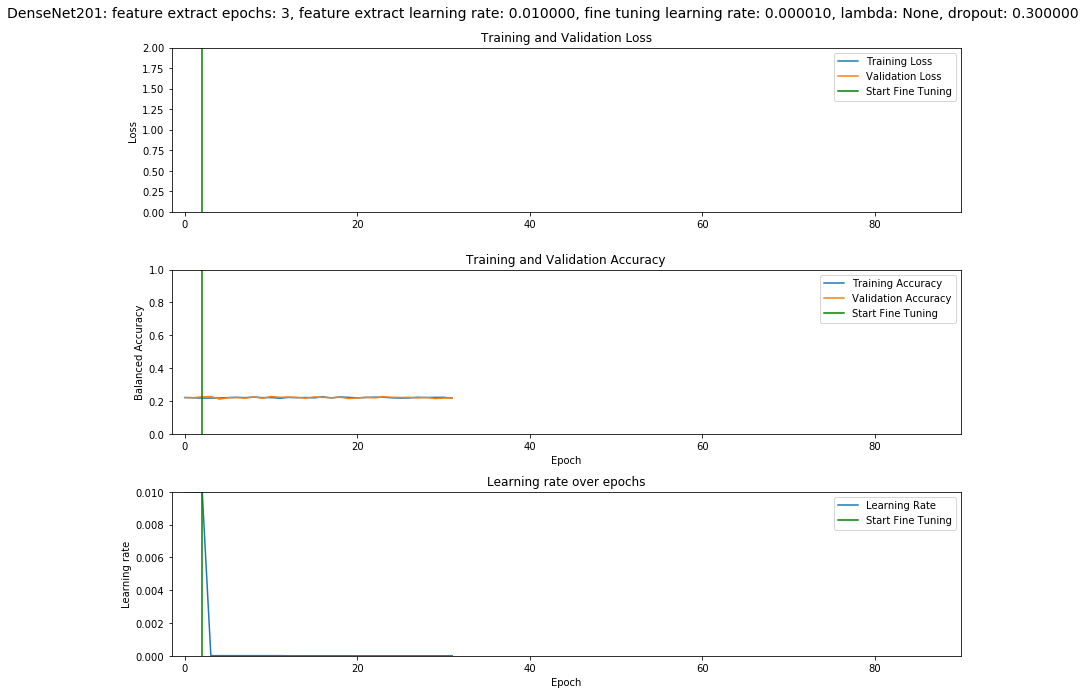

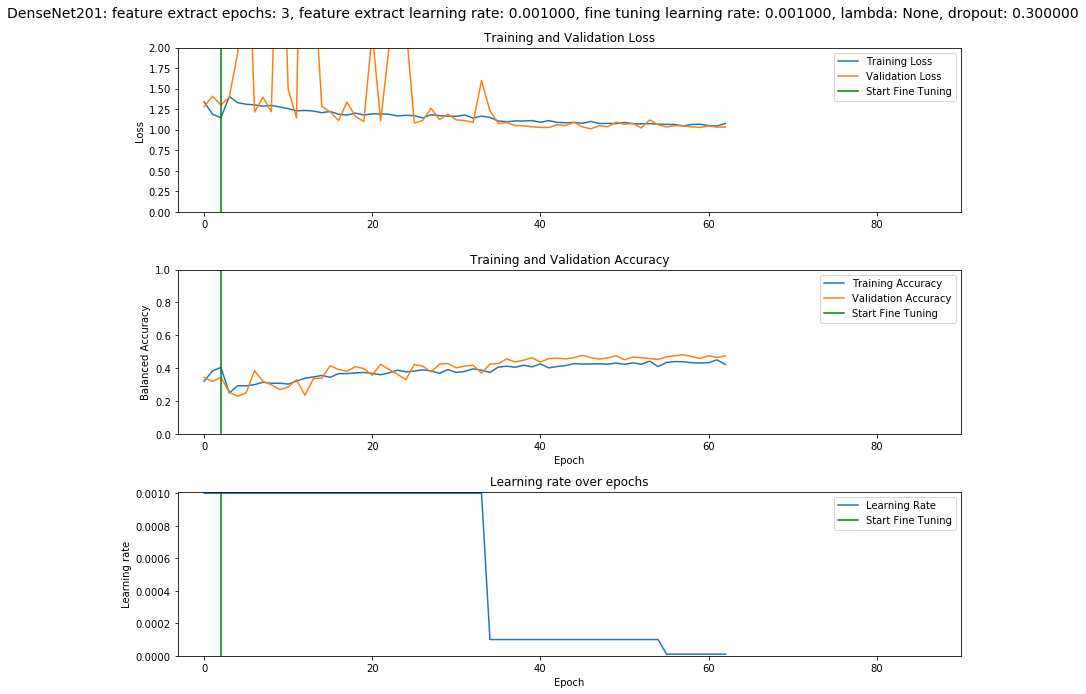

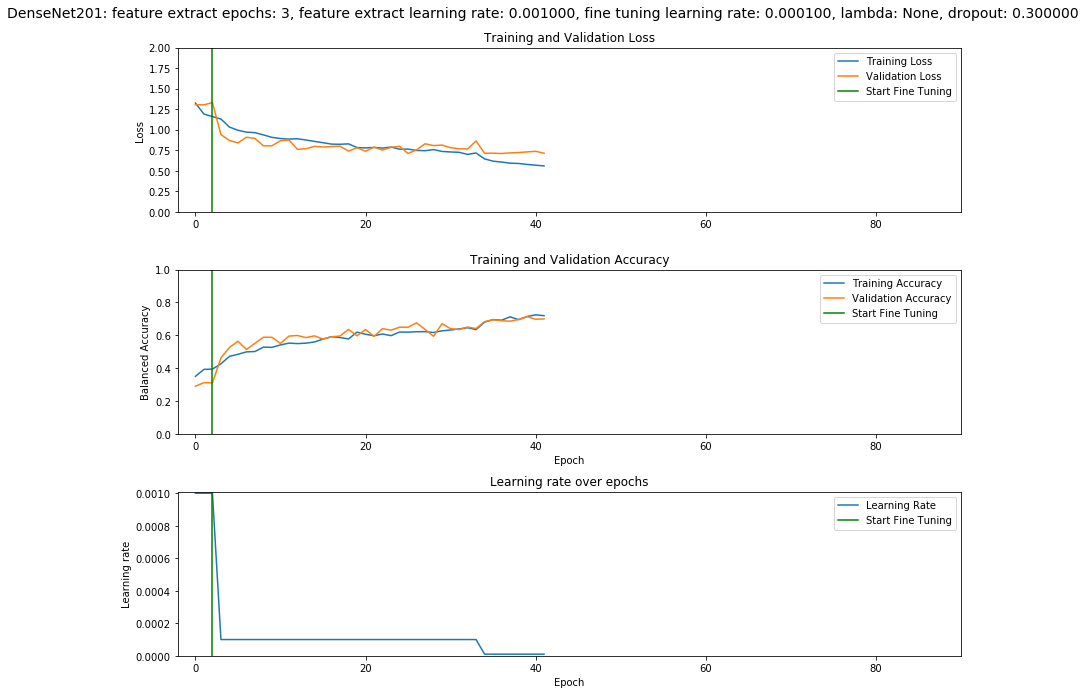

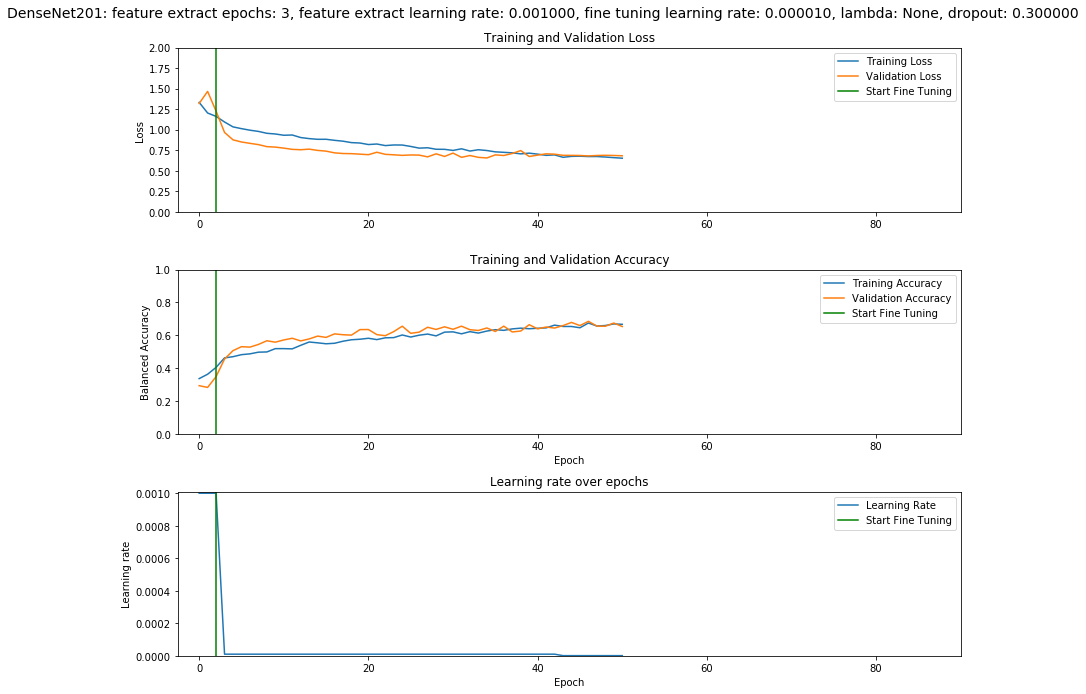

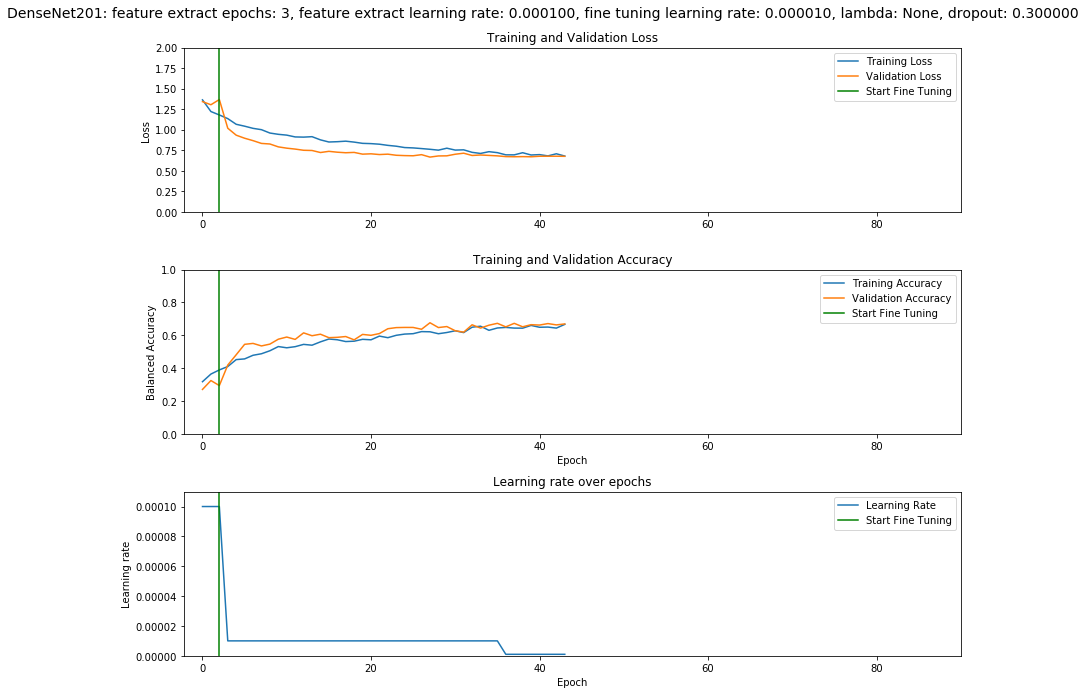

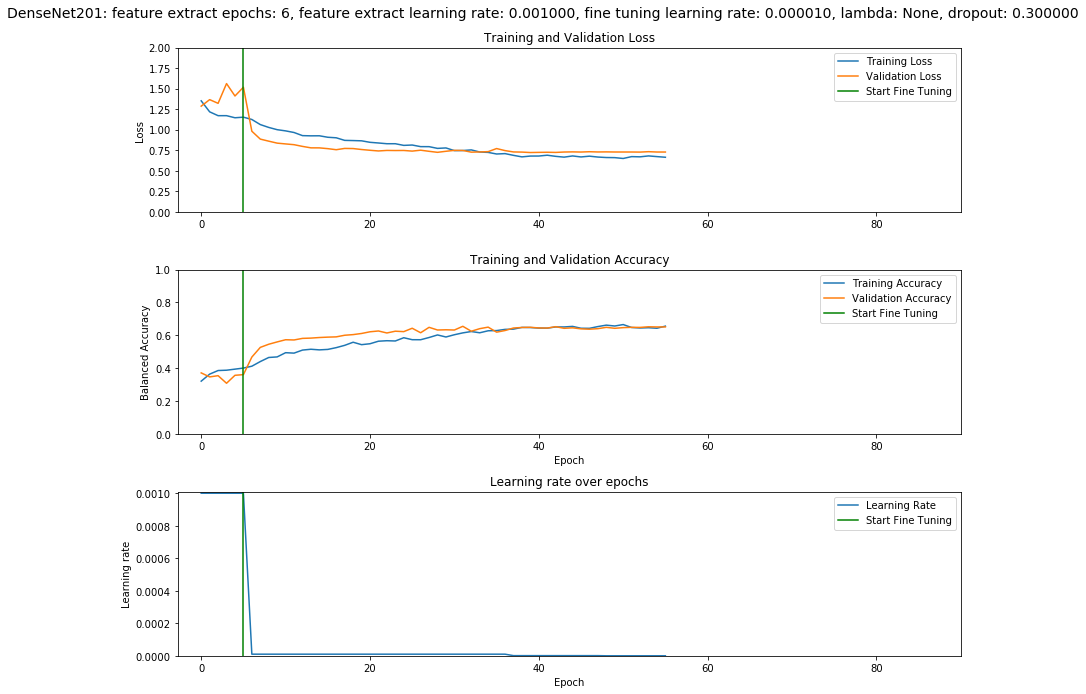

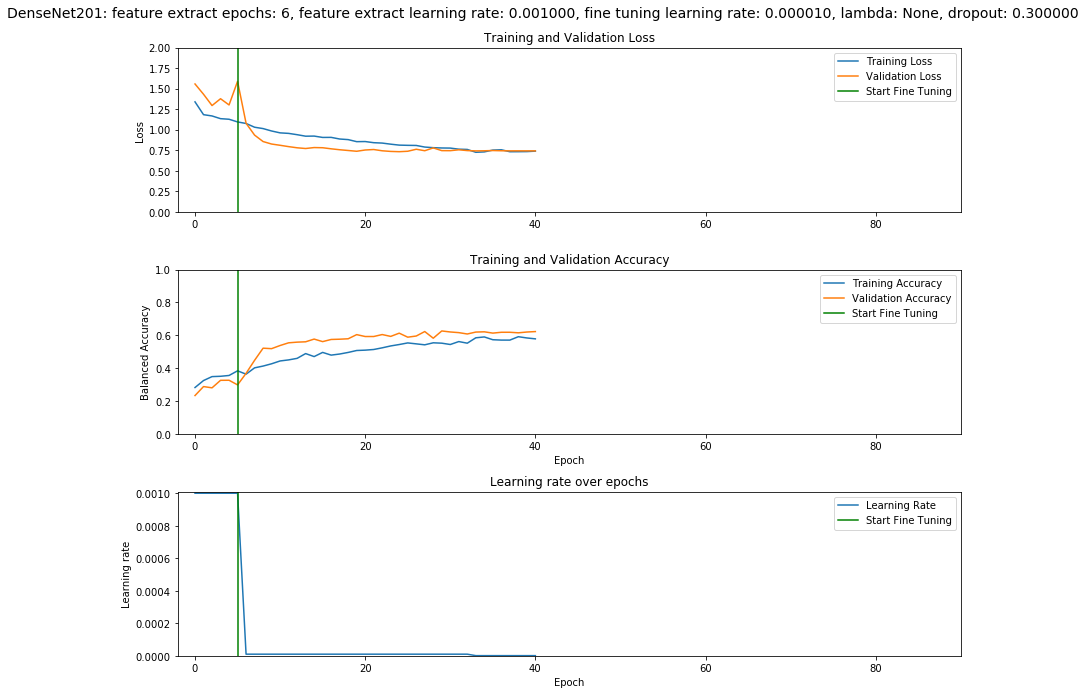

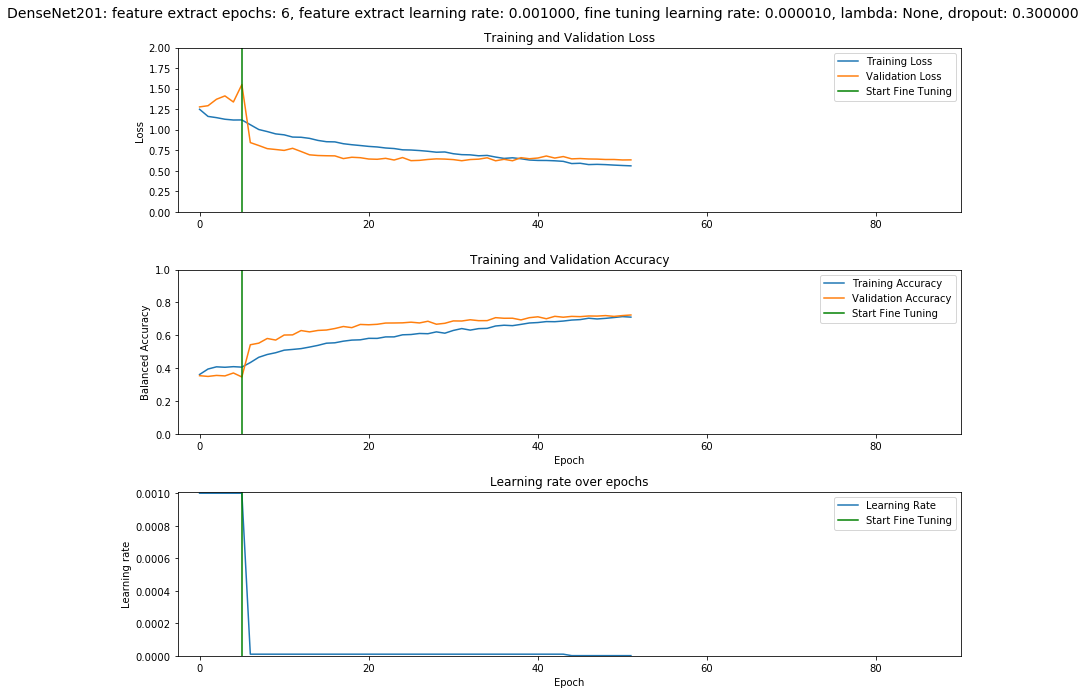

In [7]:
model_name = 'DenseNet201'
d=os.path.join("..", history_folder, model_name)
hyperparameter_combinations = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]
models_info = []

for i, combination in enumerate(hyperparameter_combinations): 
    hyperparameters = get_hyperparameters_from_str(combination)
    file_path = os.path.join("..", history_folder, model_name, combination, "training.csv")
    if(len(hyperparameters)>1 and os.path.exists(file_path)):
        model_info = {
            "log": file_path,
            "hyperparameters": hyperparameters, 
            "hyperparameters_dir": combination
        }

        fig = plot_complexity_graph(
            csv_file=file_path,
            title="{}: feature extract epochs: {}, feature extract learning rate: {}, fine tuning learning rate: {}, lambda: {}, dropout: {}".format(
                model_name, 
                hyperparameters["feepochs"],
                hyperparameters["felr"],
                hyperparameters["ftlr"],
                hyperparameters["lambda"],
                hyperparameters["dropout"]
            ),
            figsize=(12, 10),
            feature_extract_epochs=int(hyperparameters["feepochs"])
        )
        models_info.append(model_info)

### Learning rate comparisson 

#### Feature extraction learning rate

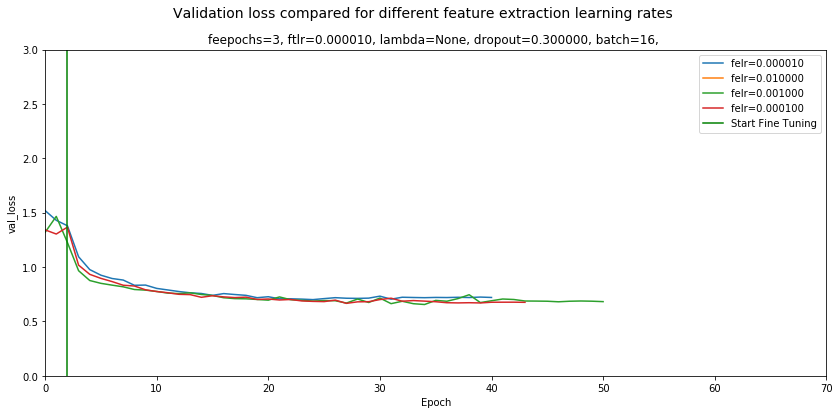

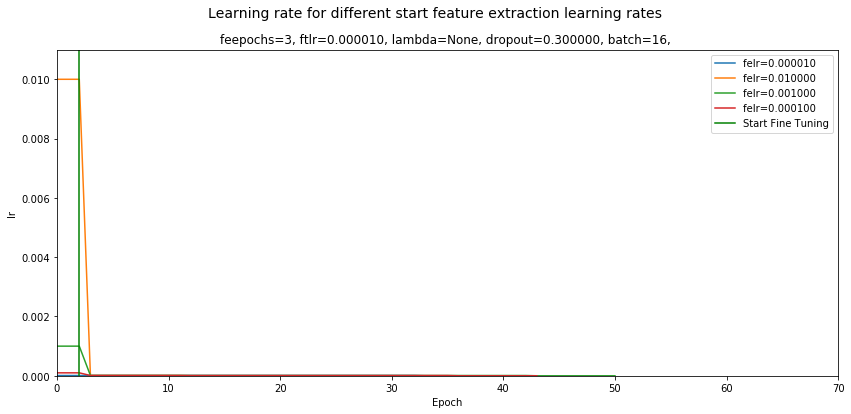

In [9]:
fig = plot_hyperparameter_comparisson_metric(
    models_info,
    "val_loss",
    0,
    3,
    hyperparameters_compared=["felr"],
    constant_parameters={
        "feepochs": 3, 
        "dropout": 0.3, 
        "ftlr": 0.00001, 
        "batch": 16,
        "lambda": None
    },
    title="Validation loss compared for different feature extraction learning rates",
    feature_extract_epochs=3,
    epoch_max=70
)

fig.savefig(
    os.path.join("..", history_folder, model_name, combination, "feature_extraction_learning_rate_loss.svg"), 
    format='svg',
    bbox_inches='tight', 
    pad_inches=0
)

fig2 = plot_hyperparameter_comparisson_metric(
    models_info,
    "lr",
    0,
    0.011,
    hyperparameters_compared=["felr"],
    constant_parameters={
        "feepochs": 3, 
        "dropout": 0.3, 
        "ftlr": 0.00001, 
        "batch": 16,
        "lambda": None
    },
    title="Learning rate for different start feature extraction learning rates",
    feature_extract_epochs=3,
    epoch_max=70
)

#### Fine tuning learning rate

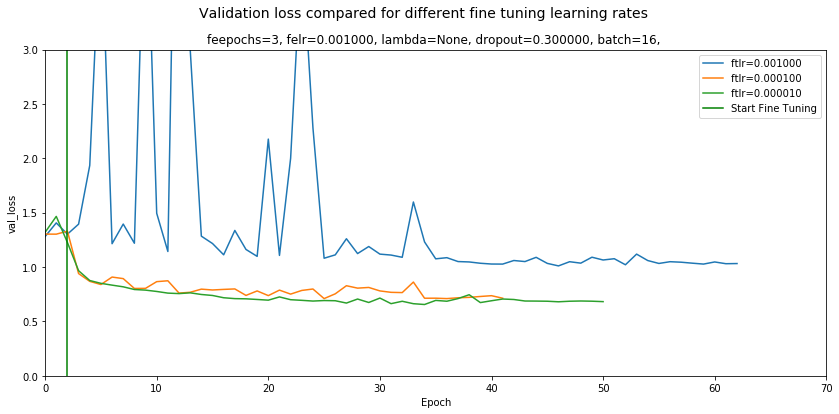

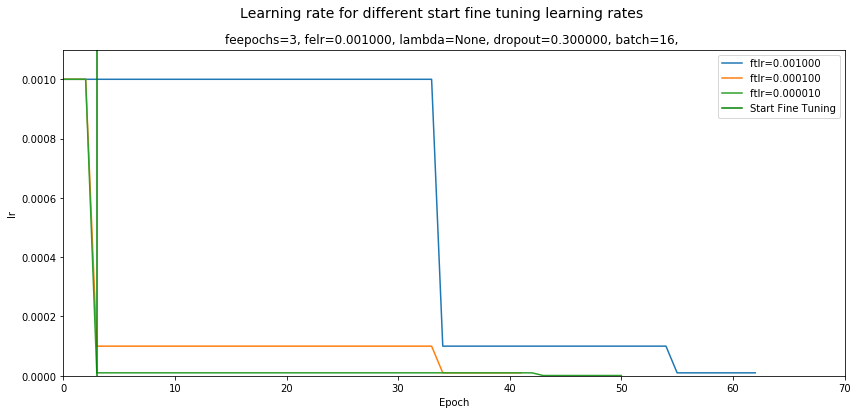

In [8]:
fig = plot_hyperparameter_comparisson_metric(
    models_info,
    "val_loss",
    0,
    3,
    hyperparameters_compared=["ftlr"],
    constant_parameters={
        "feepochs": 3, 
        "felr": 0.001, 
        "dropout": 0.3, 
        "batch": 16,
        "lambda": None
    },
    title="Validation loss compared for different fine tuning learning rates",
    feature_extract_epochs=3,
    epoch_max=70
)

fig2 = plot_hyperparameter_comparisson_metric(
    models_info,
    "lr",
    0,
    0.0011,
    hyperparameters_compared=["ftlr"],
    constant_parameters={
        "feepochs": 3, 
        "felr": 0.001, 
        "dropout": 0.3, 
        "batch": 16,
        "lambda": None
    },
    title="Learning rate for different start fine tuning learning rates",
    feature_extract_epochs=4,
    epoch_max=70
)

### Dropout comparisson 

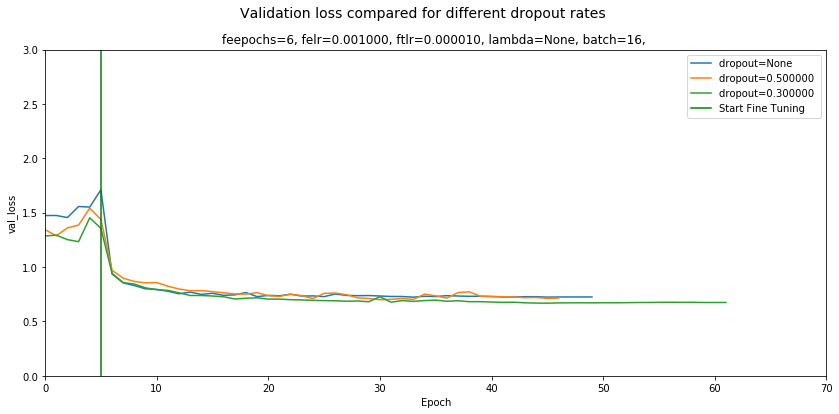

In [110]:
from visuals import *

fig = plot_hyperparameter_comparisson_metric(
    models_info,
    "val_loss",
    0,
    3,
    hyperparameters_compared=["dropout"],
    constant_parameters={
        "feepochs": 6, 
        "felr": 0.001, 
        "ftlr": 0.00001, 
        "batch": 16,
        "lambda": None
    },
    title="Validation loss compared for different dropout rates",
    feature_extract_epochs=6,
    epoch_max=70
)

fig.savefig(
    os.path.join("..", history_folder, model_name, combination, "dropout_loss.svg"), 
    format='svg',
    bbox_inches='tight', 
    pad_inches=0
)

### Feature extract epochs comparisson

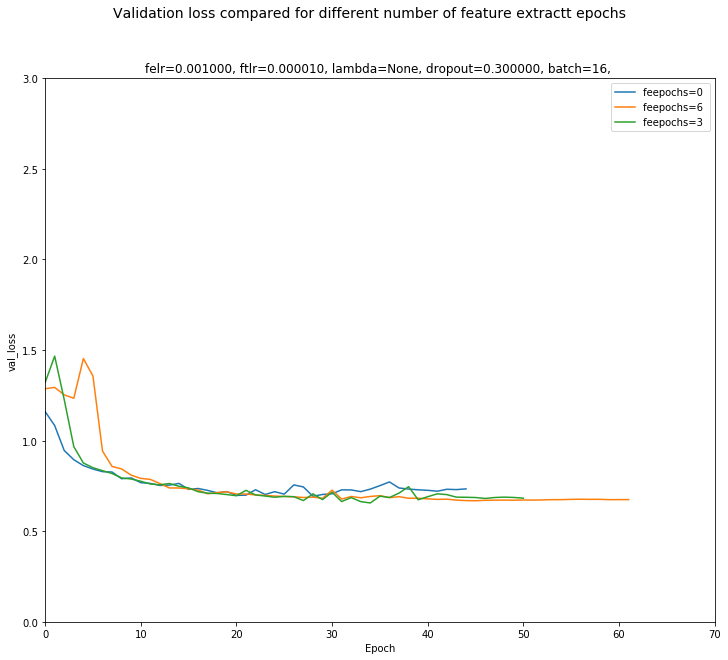

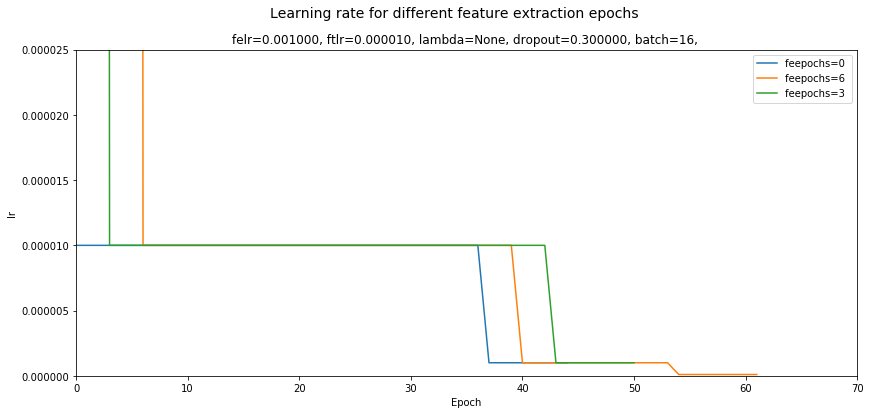

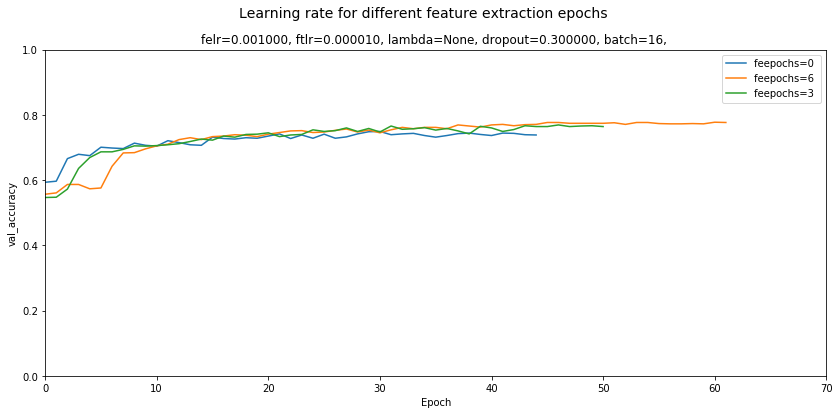

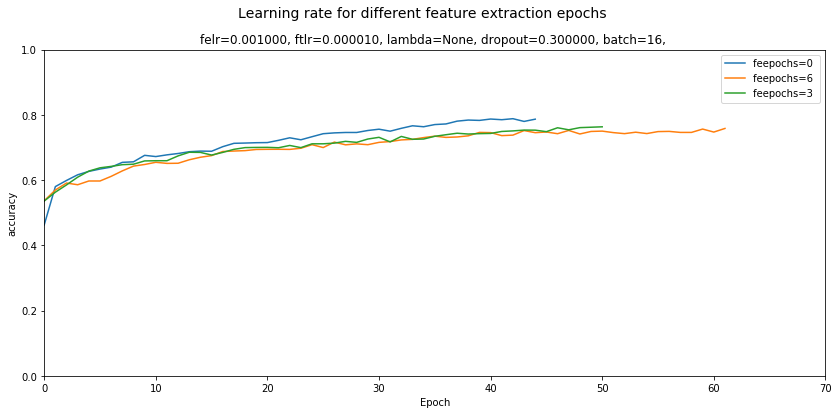

In [111]:
from visuals import *

fig = plot_hyperparameter_comparisson_metric(
    models_info,
    "val_loss",
    0,
    3,
    hyperparameters_compared=["feepochs"],
    constant_parameters={
        "dropout": 0.3, 
        "felr": 0.001, 
        "ftlr": 0.00001, 
        "batch": 16
    },
    title="Validation loss compared for different number of feature extractt epochs",
    figsize=(12, 10),
    feature_extract_epochs=None,
    epoch_max=70
)

fig.savefig(
    os.path.join("..", history_folder, model_name, combination, "dropout_loss.svg"), 
    format='svg',
    bbox_inches='tight', 
    pad_inches=0
)

fig2 = plot_hyperparameter_comparisson_metric(
    models_info,
    "lr",
    0,
    0.000025,
    hyperparameters_compared=["feepochs"],
    constant_parameters={
        "dropout": 0.3, 
        "felr": 0.001, 
        "ftlr": 0.00001, 
        "batch": 16
    },
    title="Learning rate for different feature extraction epochs",
    feature_extract_epochs=None,
    epoch_max=70
)

fig3 = plot_hyperparameter_comparisson_metric(
    models_info,
    "val_accuracy",
    0,
    1,
    hyperparameters_compared=["feepochs"],
    constant_parameters={
        "dropout": 0.3, 
        "felr": 0.001, 
        "ftlr": 0.00001, 
        "batch": 16
    },
    title="Learning rate for different feature extraction epochs",
    feature_extract_epochs=None,
    epoch_max=70
)


fig4 = plot_hyperparameter_comparisson_metric(
    models_info,
    "accuracy",
    0,
    1,
    hyperparameters_compared=["feepochs"],
    constant_parameters={
        "dropout": 0.3, 
        "felr": 0.001, 
        "ftlr": 0.00001, 
        "batch": 16
    },
    title="Learning rate for different feature extraction epochs",
    feature_extract_epochs=None,
    epoch_max=70
)

# Compute test metrics without unknown class

## Test set results on dataset portion

Test data has 1499 samples.
'MEL':	268	(17.88%)
'NV':	762	(50.83%)
'BCC':	197	(13.14%)
'AK':	51	(3.40%)
'BKL':	155	(10.34%)
'DF':	14	(0.93%)
'VASC':	37	(2.47%)
'SCC':	15	(1.00%)
'UNK':	0	(0.00%)


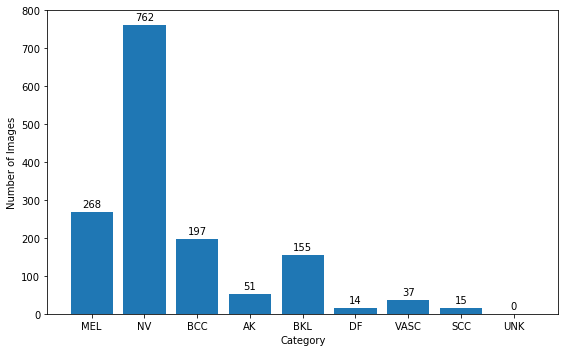

Model selection criteria: best_balanced_acc

DenseNet201:
	Train + validation sampled: 5995
	Feature extract epochs: 6
	Feature extract learning rate: 0.001000
	Fine tuning learning rate: 0.000010
	Dropout rate: 0.300000
	Lambda(l2): None
	Batch size: 16
accuracy:  0.733155436957972
balanced_accuracy_score:  0.4988152733413244
macro recall_score:  0.4988152733413244


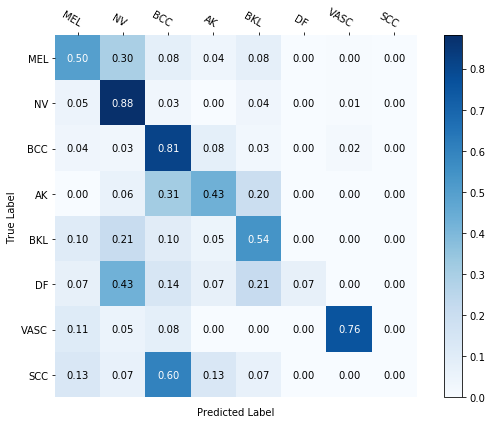

In [26]:
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from visuals import plot_confusion_matrix
from tensorflow.keras import utils
from keras_numpy_backend import categorical_crossentropy

data_folder = '../data/isic2019/sampled'

training_image_folder = os.path.join(data_folder, 'ISIC_2019_Test_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Test_GroundTruth copy.csv')

df_test_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(
    training_image_folder, 
    ground_truth_file,
    test=True
)
known_category_num = len(known_category_names)
unknown_category_num = 1
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

count_per_category = Counter(df_test_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Test data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()
plt.show()

model_name = 'DenseNet201'
postfix = 'best_balanced_acc'
pred_test_folder = os.path.join("..", 'test_predict_results_partial_no_unknown', model_name) 
print(f'Model selection criteria: {postfix}\n')

for model_info in models_info:
    # Load predicted results
    file_path = os.path.join(
        pred_test_folder, 
        model_info["hyperparameters_dir"],
        "{}.csv".format(postfix)
    )
    if not os.path.exists(file_path):
        continue

    print(f"{model_name}:") 
    print(f"\tTrain + validation sampled: {model_info['hyperparameters']['samples']}")
    print(f"\tFeature extract epochs: {model_info['hyperparameters']['feepochs']}")
    print(f"\tFeature extract learning rate: {model_info['hyperparameters']['felr']}")
    print(f"\tFine tuning learning rate: {model_info['hyperparameters']['ftlr']}")
    print(f"\tDropout rate: {model_info['hyperparameters']['dropout']}")
    print(f"\tLambda(l2): {model_info['hyperparameters']['lambda']}")
    print(f"\tBatch size: {model_info['hyperparameters']['batch']}")
    
    df_pred = pd.read_csv(file_path)
    df = pd.merge(df_pred, df_test_ground_truth, on='image')
    y_true = df['category']
    y_pred = df['pred_category']
    df.to_csv("test.csv")

    # Compute Balanced Accuracy
    print('accuracy: ', accuracy_score(y_true, y_pred))
    print('balanced_accuracy_score: ', balanced_accuracy_score(y_true, y_pred))
    print('macro recall_score: ', recall_score(y_true, y_pred, average='macro'))
    # Confusion Matrix
    plot_confusion_matrix(
        y_true, 
        y_pred, 
        known_category_names, 
        normalize=True,
        figsize=(8, 6)
    )
    plt.show()

## Test set results on full dataset 

Test data has 5067 samples.
'MEL':	904	(17.84%)
'NV':	2575	(50.82%)
'BCC':	665	(13.12%)
'AK':	173	(3.41%)
'BKL':	525	(10.36%)
'DF':	48	(0.95%)
'VASC':	51	(1.01%)
'SCC':	126	(2.49%)
'UNK':	0	(0.00%)


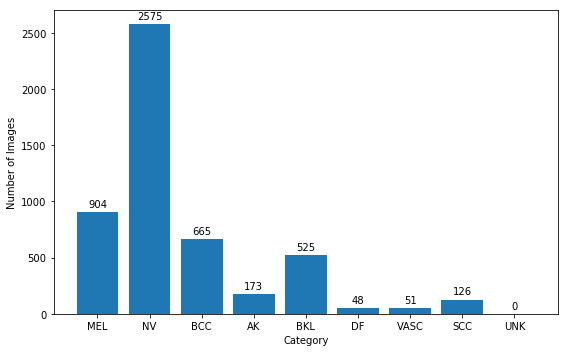

Model selection criteria: best_balanced_acc

DenseNet201:
	Train + validation sampled: 20264
	Feature extract epochs: 6
	Feature extract learning rate: 0.001000
	Fine tuning learning rate: 0.000010
	Dropout rate: 0.300000
	Lambda(l2): None
	Batch size: 16
accuracy:  0.7945529899348727
balanced_accuracy_score:  0.662233326122853
macro recall_score:  0.662233326122853


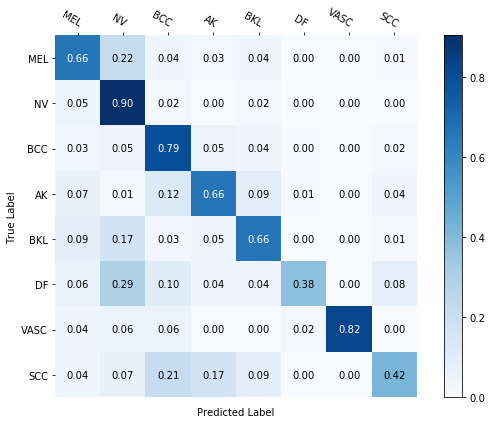

In [22]:
data_folder = '../data/isic2019/sampled_full'

training_image_folder = os.path.join(data_folder, 'ISIC_2019_Test_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Test_GroundTruth copy.csv')

df_test_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(
    training_image_folder, 
    ground_truth_file,
    test=True
)
known_category_num = len(known_category_names)
unknown_category_num = 1
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

count_per_category = Counter(df_test_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Test data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()
plt.show()

model_name = 'DenseNet201'
postfix = 'best_balanced_acc'
pred_test_folder = os.path.join("..", 'test_predict_results_no_unknown', model_name) 
print(f'Model selection criteria: {postfix}\n')

for model_info in models_info:
    # Load predicted results
    file_path = os.path.join(
        pred_test_folder, 
        model_info["hyperparameters_dir"],
        "{}.csv".format(postfix)
    )
    if not os.path.exists(file_path):
        continue

    print(f"{model_name}:") 
    print(f"\tTrain + validation sampled: {model_info['hyperparameters']['samples']}")
    print(f"\tFeature extract epochs: {model_info['hyperparameters']['feepochs']}")
    print(f"\tFeature extract learning rate: {model_info['hyperparameters']['felr']}")
    print(f"\tFine tuning learning rate: {model_info['hyperparameters']['ftlr']}")
    print(f"\tDropout rate: {model_info['hyperparameters']['dropout']}")
    print(f"\tLambda(l2): {model_info['hyperparameters']['lambda']}")
    print(f"\tBatch size: {model_info['hyperparameters']['batch']}")
    
    df_pred = pd.read_csv(file_path)
    df = pd.merge(df_pred, df_test_ground_truth, on='image')
    y_true = df['category']
    y_pred = df['pred_category']
    df.to_csv("test.csv")

    # Compute Balanced Accuracy
    print('accuracy: ', accuracy_score(y_true, y_pred))
    print('balanced_accuracy_score: ', balanced_accuracy_score(y_true, y_pred))
    print('macro recall_score: ', recall_score(y_true, y_pred, average='macro'))
    # Confusion Matrix
    plot_confusion_matrix(
        y_true, 
        y_pred, 
        known_category_names, 
        normalize=True,
        figsize=(8, 6)
    )
    plt.show()